In [1]:
import numpy as np
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt

1*. Измените функцию calc_logloss так, чтобы нули по возможности не попадали в np.log.  

In [2]:
def calc_logloss(y, y_pred, eps=1e-15):
    y_pred = np.where(y_pred > (1 - eps), 1 - eps, np.where(y_pred < eps, eps, y_pred))
    err = - np.mean(y * np.log(y_pred) + (1.0 - y) * np.log(1.0 - y_pred))
    return err

In [3]:
assert calc_logloss(np.array([1., 1.]), np.array([0., 0.])) == calc_logloss(np.array([1., 1.]), np.array([1e-15, 1e-15]))
assert calc_logloss(np.array([1., 1.]), np.array([1., 1.])) == calc_logloss(np.array([1., 1.]), np.array([1 - 1e-15, 1 - 1e-15]))
assert calc_logloss(np.array([1., 0.]), np.array([0.8, 0.1])) == log_loss(np.array([1., 0.]), np.array([0.8, 0.1]))
assert calc_logloss(np.array([1., 0.]), np.array([0., 0.])) == log_loss(np.array([1., 0.]), np.array([0., 0.]))

2. Подберите аргументы функции eval_model для логистической регрессии таким образом, чтобы log loss был минимальным.

In [4]:
def sigmoid(z):
    res = 1 / (1 + np.exp(-z))
    return res

def eval_model(X, y, iterations, alpha=1e-4):
    np.random.seed(42)
    W = np.random.randn(X.shape[0])
    n = X.shape[1]
    err_history = []
    W_history = []
    for i in range(1, iterations+1):
        z = np.dot(W, X)
        y_pred = sigmoid(z)
        err = calc_logloss(y, y_pred, eps=1e-15)
        W -= alpha * (1/n * np.dot((y_pred - y), X.T))
        err_history.append(err)
        W_history.append(W)
    return W, err, np.array(err_history), np.array(W_history)

In [5]:
X = np.array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
              [1, 1, 2, 1, 3, 0, 5, 10, 1, 2],
              [500, 700, 750, 600, 1450,
               800, 1500, 2000, 450, 1000],
              [1, 1, 2, 1, 2, 1, 3, 3, 1, 2]], dtype = np.float64)

y = np.array([0, 0, 1, 0, 1, 0, 1, 0, 1, 1], dtype = np.float64)

In [6]:
W = eval_model(X, y, iterations=500, alpha=1e-5)
W[:-2]

(array([ 0.49579478, -0.14021162, -0.00414974,  1.52229183]),
 0.8478930381998916)

Подберем способ масштабирования данных обеспечивающий минимальное значение функции потерь

In [7]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler

In [8]:
_, min_scaler_loss, _, _ = eval_model(X, y, iterations=500, alpha=1e-5)
scalers = [MinMaxScaler(), RobustScaler(), StandardScaler()]
best_scaler = None
for scaler in scalers:
    X_scaled = scaler.fit_transform(X)
    _, scaler_loss, _, _ = eval_model(X_scaled, y, iterations=500, alpha=1e-4)
    if scaler_loss < min_scaler_loss:
        min_scaler_loss = scaler_loss
        best_scaler = scaler
print(f'best scaler: {best_scaler} loss: {min_scaler_loss}')

best scaler: StandardScaler() loss: 0.6932149352667696


In [9]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

В дальнейшем не использовал масштабирование признаков так как это проводило к неадекватным результатам, при различных параметрах обучения

Визуализируем изменение функции ошибки при различных значениях скорости обучения

0.0001 [ 0.47437348 -0.16761096  0.04089006  1.56894771] 2.3207568321112637
1e-05 [ 0.49314177 -0.14151841 -0.00414786  1.52547952] 0.8471318040263481
1e-06 [ 0.49571367 -0.13987934 -0.00243104  1.52220861] 0.6047007196667514


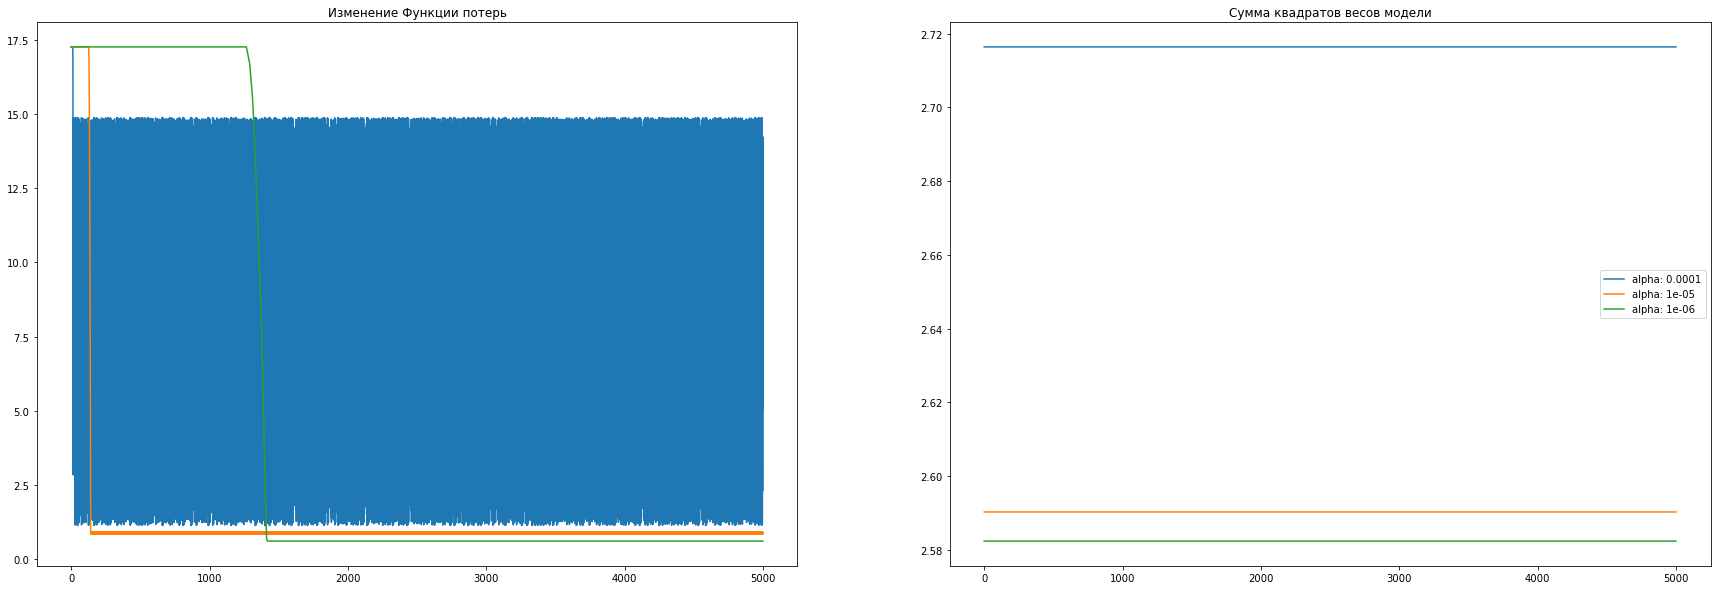

In [10]:
alpha_values = [1e-4, 1e-5, 1e-6]

plt.rcParams["figure.figsize"] = (30, 10)
f, (ax1, ax2) = plt.subplots(1, 2)
ax1.set_title('Изменение Функции потерь')
ax2.set_title('Сумма квадратов весов модели')
for alpha in alpha_values:
    W, final_loss, err_history, W_history = eval_model(X, y, iterations=5000, alpha=alpha)
    ax1.plot(err_history, label=f'alpha: {alpha}')
    ax2.plot([sum(W ** 2) for W in W_history], label=f'alpha: {alpha}')
    print(alpha, W, final_loss)
plt.legend()
plt.show()

При увеличении скорости обучения модель переобучается, оптимальное значение скорости обучения для данной задачи alpha=1e-5, функция ошибки резко падает около 150 итераций, обучим модель при заданных параметрах


In [11]:
W, final_loss, err_history, W_history = eval_model(X, y, iterations=5000, alpha=1e-5)
W, final_loss

(array([ 0.49314177, -0.14151841, -0.00414786,  1.52547952]),
 0.8471318040263481)

3. Создайте функцию calc_pred_proba, возвращающую предсказанную вероятность класса 1 (на вход подаются W, который уже посчитан функцией eval_model и X, на выходе - массив y_pred_proba).

In [12]:
def calc_pred_proba(X, W):
    return sigmoid(np.dot(W, X))

In [13]:
calc_pred_proba(X, W)

array([0.45095143, 0.26378276, 0.5374718 , 0.35169127, 0.05240864,
       0.21422107, 0.13472611, 0.00955278, 0.50264141, 0.2917714 ])

4. Создайте функцию calc_pred, возвращающую предсказанный класс (на вход подаются W, который уже посчитан функцией eval_model и X, на выходе - массив y_pred).

In [14]:
def calc_pred(X, W, threshold=0.5):
    return np.where(calc_pred_proba(X, W) >= threshold, 1, 0)

In [15]:
y_pred = calc_pred(X, W)
y_pred, y

(array([0, 0, 1, 0, 0, 0, 0, 0, 1, 0]),
 array([0., 0., 1., 0., 1., 0., 1., 0., 1., 1.]))

5. Посчитайте Accuracy, матрицу ошибок, точность и полноту, а также F1 score.

In [16]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [17]:
def calc_accuracy(y, y_pred):
    return sum(y == y_pred) / len(y)

accuracy = calc_accuracy(y, y_pred)
assert accuracy == accuracy_score(y, y_pred)
print(accuracy)

0.7


In [18]:
def calc_confusion_matrix(y, y_pred):
    pred_types = y + np.dot(2, y_pred)
    TP = len(pred_types[pred_types == 3])
    TN = len(pred_types[pred_types == 0])
    FP = len(pred_types[pred_types == 2])
    FN = len(pred_types[pred_types == 1])
    return np.array([[TP, FN], [FP, TN]])

In [19]:
cm = calc_confusion_matrix(y, y_pred)
assert (cm == confusion_matrix(y, y_pred, labels=[1, 0])).all()
print(cm)

[[2 3]
 [0 5]]


In [20]:
precision = cm[0][0] / sum(cm[:,0])
recall = cm[0][0] / sum(cm[0])
f1 = 2 * precision * recall / (precision + recall)
assert precision == precision_score(y, y_pred)
assert recall == recall_score(y, y_pred)
assert f1 == f1_score(y, y_pred)
precision, recall, f1

(1.0, 0.4, 0.5714285714285715)

6. Могла ли модель переобучиться? Почему?

Исходя из анализа кривых обучения, модель склонна к переобучению при большом значении параметра скорости обучения